In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Flatten, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [16]:
depression = pd.read_csv('../data/depression_30k.csv')
anxiety = pd.read_csv('../data/anxiety_20k.csv')
basetext = pd.read_csv('../data/basetext.csv')

In [17]:
depression.drop(columns='Unnamed: 0',inplace=True)
anxiety.drop(columns='Unnamed: 0',inplace=True)
basetext.drop(columns='Unnamed: 0',inplace=True)

In [18]:
dep = depression.sample(1000)
bas = basetext.sample(1000)
anx = anxiety.sample(1000)

In [19]:
sample_df = pd.concat([dep,bas,anx])

In [20]:
analyzer = SentimentIntensityAnalyzer()

In [21]:
def sentiment(row):
    analyzer = SentimentIntensityAnalyzer()
    res = analyzer.polarity_scores(row)
    return pd.Series([res['neg'], res['neu'], res['pos'], res['compound']])

In [22]:
sample_df.replace('[removed]','',inplace=True)
sample_df.replace('[deleted]','',inplace=True)

In [23]:
sample_df['full_text'] = sample_df['title'] + " " + sample_df['selftext']

In [24]:
sample_df['full_text'] = sample_df['full_text'].astype(str)

In [25]:
sample_df[['neg','neu','pos','comp']] = sample_df['full_text'].apply(sentiment)

In [26]:
sample_df

,title,author,selftext,created_utc,subreddit,full_text,neg,neu,pos,comp
29038,Cost of counseling and is it worth it?,DJDeadPixel,"Title says it all. If you've tried counseling,...",1598631983,depression,Cost of counseling and is it worth it? Title s...,0.000,0.763,0.237,0.7550
20840,Hey humans!,sunnshinerider,Since this is a dark place for ppl with dark s...,1599755764,depression,Hey humans! Since this is a dark place for ppl...,0.047,0.771,0.183,0.9891
2963,"Feeling lost, jaded and a lack of motivation i...",SenobiWolf,Hi all\~\n\nThis is my first post and I have b...,1602314515,depression,"Feeling lost, jaded and a lack of motivation i...",0.142,0.693,0.166,0.9773
21539,The shitty people are the most successful and ...,iseethedanger,"Is it just me, or does anyone else ever feel l...",1599651970,depression,The shitty people are the most successful and ...,0.169,0.687,0.144,-0.8930
3110,Identity crisis anyone?,SydVicious1991,Idk if it has anything to do with my depressio...,1602296792,depression,Identity crisis anyone? Idk if it has anything...,0.121,0.774,0.106,0.4497
...,...,...,...,...,...,...,...,...,...,...
16252,Sunday nights are the worst.,sneakyturtles7,Every Sunday night I feel anxious and depresse...,1597626626,Anxiety,Sunday nights are the worst. Every Sunday nigh...,0.309,0.691,0.000,-0.8555
18262,A tip for anxiety when going to the doctors,927aigroege,"If you struggle with doctor's appointments, so...",1597026015,Anxiety,A tip for anxiety when going to the doctors If...,0.097,0.843,0.060,-0.6805
10765,Mandatory COVID Test Tomorrow announced Today,juliettesierra,I’m at college right now since I thought I’d f...,1599196727,Anxiety,Mandatory COVID Test Tomorrow announced Today ...,0.115,0.739,0.146,0.6992
15637,Please Read: Looking for Guidance on Job-Relat...,RealityRestored,"Hello all,\n\nI should probably begin by provi...",1597796426,Anxiety,Please Read: Looking for Guidance on Job-Relat...,0.102,0.831,0.067,-0.8471


In [27]:
use_df = sample_df[['full_text', 'neg', 'neu', 'pos', 'comp', 'subreddit']]
use_df.reset_index(inplace=True)

In [28]:
use_df['subreddit'].unique()

array(['depression', 'CasualConversation', 'happy', 'Anxiety'],
      dtype=object)

### Modeling

In [29]:
X = use_df.drop(columns='subreddit')
y = use_df['subreddit'].map({'CasualConversation':0, 'happy':0, 'Anxiety':1, 'depression':2})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

In [ ]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_trf_bertbaseuncased_lg"):    #put bert embeddings here
        self.model = model
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

In [ ]:
bertvect = WordVectorTransformer()

In [ ]:
X_train_bvect = bertvect.fit_transform(X_train['full_text'])
X_test_bvect = bertvect.transform(X_test['full_text'])

In [65]:
y_train_vect = tf.keras.utils.to_categorical(y_train)
y_test_vect = tf.keras.utils.to_categorical(y_test)

In [66]:
X_train_bvect.shape

(2250, 768)

In [67]:
X_train_bvect.shape

(2250, 768)

In [77]:
type(X_train_bvect)

numpy.ndarray

In [84]:
X_train_bvect.shape

(2250, 768)

In [112]:
train_neg = X_train['neg'].to_numpy().reshape(-1,1)
train_pos = X_train['pos'].to_numpy().reshape(-1,1)
train_comp = X_train['comp'].to_numpy().reshape(-1,1)

In [113]:
test_neg = X_test['neg'].to_numpy().reshape(-1,1)
test_pos = X_test['pos'].to_numpy().reshape(-1,1)
test_comp = X_test['comp'].to_numpy().reshape(-1,1)

In [126]:
X_train_new = np.concatenate((X_train_bvect, train_neg, train_pos, train_comp),axis=1)
X_train_new.shape

(2250, 771)

In [127]:
X_test_new = np.concatenate((X_test_bvect, test_neg, test_pos, test_comp),axis=1)
X_test_new.shape

(750, 771)

In [206]:
model_k = Sequential()
model_k.add(Flatten())
model_k.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_k.add(Dropout(0.5))
model_k.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_k.add(Dropout(0.5))
model_k.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_k.add(Dropout(0.5))
model_k.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))
model_k.add(Dropout(0.4))


model_k.add(Dense(3, activation='softmax'))

In [207]:
model_k.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [208]:
history_k = model_k.fit(X_train_new,y_train_vect,validation_data = (X_test_new,y_test_vect),epochs=300,verbose=0)

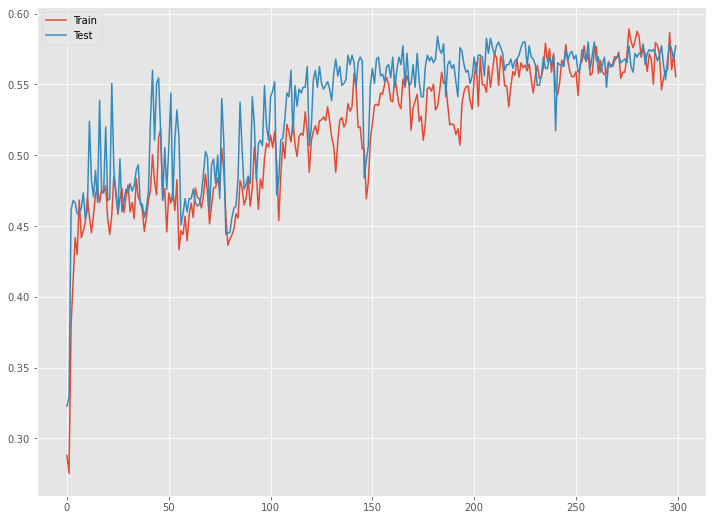

In [210]:
plt.style.use('ggplot')
plt.figure(figsize=(12,9))
plt.plot(history_k.history['accuracy'],label='Train')
plt.plot(history_k.history['val_accuracy'],label='Test')
plt.legend()

In [ ]:
model_k = Sequential()
model_k.add(Flatten())
model_k.add(LSTM())
model_k.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_k.add(Dropout(0.5))
model_k.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_k.add(Dropout(0.5))
model_k.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_k.add(Dropout(0.5))
model_k.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))
model_k.add(Dropout(0.4))

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
use_df.shape

(3000, 7)

In [32]:
use_df.head()

,index,full_text,neg,neu,pos,comp,subreddit
0,29038,Cost of counseling and is it worth it? Title s...,0.000,0.763,0.237,0.7550,depression
1,20840,Hey humans! Since this is a dark place for ppl...,0.047,0.771,0.183,0.9891,depression
2,2963,"Feeling lost, jaded and a lack of motivation i...",0.142,0.693,0.166,0.9773,depression
3,21539,The shitty people are the most successful and ...,0.169,0.687,0.144,-0.8930,depression
4,3110,Identity crisis anyone? Idk if it has anything...,0.121,0.774,0.106,0.4497,depression


In [33]:
#parameters for tokenization
max_len = 100
training_samples = 2500
validation_samples = 500
max_words = 10_000

In [34]:
#instantiate the tokenizer
tokenizer = Tokenizer(num_words=max_words)

In [35]:
#fit the tokenizer
tokenizer.fit_on_texts(use_df['full_text'])

In [36]:
#create the sequences
sequences = tokenizer.texts_to_sequences(use_df['full_text'])

In [37]:
#pad sequences
data = pad_sequences(sequences, maxlen=max_len)

In [46]:
#create train/test sets
X_train = data[:training_samples]
X_test = data[training_samples:training_samples + validation_samples]

y_train = y[:training_samples].map({'happy':0,'CasualConversation':0, 'depression':1})
y_test = y[training_samples: training_samples + validation_samples].map({'happy':0,'CasualConversation':0, 'depression':1})

In [51]:
X_train_reshape = X_train.reshape(-1,1)
X_test_reshape = X_test.reshape(-1,1)

In [43]:
sequences[:1]
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 2046,    7, 2154,    3,
         15,    8,  727,    8, 1315,  515,    8,   36,   38, 1858,  239,
       2154,   19,    8,  727,    8,  156,    8,   85, 4600,  124, 4601,
         27])

In [47]:
model = Sequential()
model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [49]:
model.compile(optimizer='adam', metrics=['accuracy', 'recall'], loss='binary_crossentropy')

In [52]:
history = model.fit(X_train_reshape, y_train, validation_data=(X_test_reshape,y_test), epochs=1)

ValueError: Data cardinality is ambiguous:
  x sizes: 250000
  y sizes: 2500
Please provide data which shares the same first dimension.

In [54]:
use_df

,index,full_text,neg,neu,pos,comp,subreddit
0,29038,Cost of counseling and is it worth it? Title s...,0.000,0.763,0.237,0.7550,depression
1,20840,Hey humans! Since this is a dark place for ppl...,0.047,0.771,0.183,0.9891,depression
2,2963,"Feeling lost, jaded and a lack of motivation i...",0.142,0.693,0.166,0.9773,depression
3,21539,The shitty people are the most successful and ...,0.169,0.687,0.144,-0.8930,depression
4,3110,Identity crisis anyone? Idk if it has anything...,0.121,0.774,0.106,0.4497,depression
...,...,...,...,...,...,...,...
2995,16252,Sunday nights are the worst. Every Sunday nigh...,0.309,0.691,0.000,-0.8555,Anxiety
2996,18262,A tip for anxiety when going to the doctors If...,0.097,0.843,0.060,-0.6805,Anxiety
2997,10765,Mandatory COVID Test Tomorrow announced Today ...,0.115,0.739,0.146,0.6992,Anxiety
2998,15637,Please Read: Looking for Guidance on Job-Relat...,0.102,0.831,0.067,-0.8471,Anxiety
